In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2

In [2]:
from sympy import sqrt, cos, sin,  cosh,  sinh, Add
from sympy import Symbol, S, oo, Rational, Function, pi , factorial, O, symbols, lambdify, I
from sympy import Derivative, series, limit, Matrix, simplify, collect, solve, Poly, poly, diff, nsolve, transpose, factor_terms
from sympy import latex, init_printing
from sympy.core.numbers import NegativeOne, One, Zero
from sympy.printing.latex import print_latex

import numpy as np
from tqdm import tqdm
import ray
import time

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

from acchamiltoniansandmatrices.Tracking.LinearMatrixTracking import nestList, GenerateNDimCoordinateGrid
from acchamiltoniansandmatrices.Hamiltonians.LatticeElementHamiltonians import HamDrift6D, HamQuad6D
from acchamiltoniansandmatrices.Hamiltonians.Operators import Poisson
from acchamiltoniansandmatrices.LieMaps.Poisson import PoissonBracket
from acchamiltoniansandmatrices.LieMaps.LieOperator import LieOperator
from acchamiltoniansandmatrices.Utils.Plotting import multi_countour_plot
from acchamiltoniansandmatrices.Factorization.Factorization import truncate, taylorize, dragt_finn_factorization
from acchamiltoniansandmatrices.Utils.Polynomials import getpoly, RotationMatrix2D, explicitCheck, geteigenvects
from acchamiltoniansandmatrices.Matrices.NumpyMatrices import RnpQuad6DChroma
from acchamiltoniansandmatrices.Matrices.SymbMatrices import RsymbQuad6DChroma
from acchamiltoniansandmatrices.Integrators import integrator

In [3]:
%matplotlib notebook
init_printing() 
ray.init()

2021-03-22 15:20:51,530	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8266


{'node_ip_address': '192.168.0.38',
 'raylet_ip_address': '192.168.0.38',
 'redis_address': '192.168.0.38:56076',
 'object_store_address': '/tmp/ray/session_2021-03-22_15-20-50_190875_16000/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-03-22_15-20-50_190875_16000/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2021-03-22_15-20-50_190875_16000',
 'metrics_export_port': 44191,
 'node_id': '45dc31e8b9e58bf266e7b18be8c56488a113ac4f44dd6d9cf7007510'}

In [4]:
x, px, y, py, z, delta = symbols('x p_x y p_y z delta', real=True)
eps, h , k0, k1, k2, sigma, betag = symbols('epsilon h k_0 k_1 k_2 sigma beta_gamma', real=True)
L, beta0, gamma0 = symbols(" L beta_0 gamma_0", real=True, positive=True)
x0,px0 = symbols('x_0 px_0') # to not overwrite anything

# redefine for use in ringham - otherwise assumption errors
LQF   = symbols("L_{QF}")
LQD   = symbols("L_{QD}")
LD    = symbols("L_D")
LD2   = symbols("L_{D2}")
KQF   = symbols("K_{QF}")
KQD   = symbols("K_{QD}")
dld   = symbols('\delta{L_D}') # delta length drift

In [5]:
# standardized substitutions that are useful - ORDER IN LISTS COUNTS !!!!
betagamma_rep = list(zip([beta0 * gamma0, beta0],[oo,1]))
series_rep    = list(zip([px,py,delta],[eps*px,eps*py,eps*delta]))
coord_rep     = list(zip([x,y],[eps*x,eps*y]))
thin_rep      = list(zip([px,py,delta],[0,0,0]))
xpx_rep       = list(zip([y,py,delta],[0,0,0]))
eps_rep       = list(zip([x,y,z,px,py,delta],[eps*x,eps*y,0,px*eps,py*eps,0]))
xyplane_rep   = list(zip([y,py,z,delta],[0,0,0,0]))
track_rep     = list(zip([x,px],[x0,px0]))
inv_track_rep = list(zip([x0,px0],[x,px]))

In [18]:
#Island setting
_ld1 = 2.55
_ld2 = 2.35 #2.48
_lqf = 0.3
_lqd = 0.804
_k1  = 0.7
_k2  = - 0.35

repj = list(zip([LD,LD2,LQF,LQD,KQF,KQD,dld],[_ld1,_ld2,_lqf,_lqd,_k1,_k2,0]))

In [19]:
#Island setting
_ld1 = 3.5805
_ld2 = 3.5805
_lqf = 0.342
_lqd = 0.668
_k1  = 0.49
_k2  = - 0.4999

rept = list(zip([LD,LD2,LQF,LQD,KQF,KQD,dld],[_ld1,_ld2,_lqf,_lqd,_k1,_k2,0]))

In [20]:
eldict = { 'drift' : 1, 'quad'  : 2, 'squad' : 25, 'sext'  : 3}

beamlines = [
    [eldict['quad'] , 4, LQF, KQF, 0],
    [eldict['drift'], 4, LD , Zero(), 0   ],
    [eldict['quad'] , 4, LQD, KQD, 0],
    [eldict['drift'], 4, LD , Zero(), 0   ],
    [eldict['quad'] , 4, LQF, KQF, 0],
]

In [21]:
def AssignHam(element, order=3, length=1, k=1,flag=1):
    '''
    Element:
    1 = drift space
    2 = quadrupole
    25 = skew quadrupole
    3 = sextupole
    35 = skew sextupole - tbp
    '''
    order = order +1
 
    if element == 1:
        # drift hamiltonian
        H = NegativeOne() * HamDrift6D(beta0, gamma0, length,x,px,y,py,delta)
        H = H.subs(betagamma_rep)
        H = H.subs(series_rep).series(eps,0,n=order).removeO()
        H = simplify(H.subs(eps,One()) - H.subs(eps,Zero()))

        
    elif element == 2:
        # quadrupole - thin is set by flag
        H = NegativeOne() * HamQuad6D(beta0,gamma0,length,x,px,y,py,delta,k)
        H = H.subs(betagamma_rep)
        H = H.subs(series_rep).series(eps,n=order).removeO()
        H = H.subs(coord_rep)
        H = simplify(H.subs(eps,One()) - H.subs(eps,Zero()))
        
        if flag:
            H = H.subs(thin_rep)
        
#         H = quad(order, length, strength, flag)
    elif element == 25:
        H = NegativeOne() *  HamSQuad6D(beta0,gamma0,length,x,px,y,py,delta,k)
        H = H.subs(betagamma_rep)
        H = H.subs(series_rep).series(eps,n=order).removeO()
        H = H.subs(coord_rep)
        H = simplify(H.subs(eps,One()) - H.subs(eps,Zero()))
        
        if flag:
            H = H.subs(thin_rep)
#         H = skew_quad(order, length, strength, flag)
        
    elif element == 3:
        H = NegativeOne() *  HamSext6D(beta0,gamma0,length,x,px,y,py,delta,k)
        H = H.subs(betagamma_rep)
        H = H.subs(series_rep).series(eps,n=order).removeO()
        H = H.subs(coord_rep)
        H = simplify(H.subs(eps,One()) - H.subs(eps,Zero()))
        
        if flag:
            H = H.subs(thin_rep)

    else:
        raise ValueError(element, ' no such reference in library.')      
    
    return H

In [22]:
def New_FIG(x,px,y,py,d2=False):
    fig = plt.figure(constrained_layout=True, figsize = (12,6))
    
    if d2:
        gs  = fig.add_gridspec(1, 2)
        ax1 = fig.add_subplot(gs[0,0])
        ax2 = fig.add_subplot(gs[0,1])
        ax2.set_xlabel('$y$')
        ax2.set_ylabel('$p_y$')
        ax2.plot(y,py,'k.',alpha=.1, label='Exact')
    else:
        gs  = fig.add_gridspec(1, 1)
        ax1 = fig.add_subplot(gs[0,0])

    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$p_x$')
    ax1.plot(x,px,'k.',alpha=.1, label='Exact')

In [23]:
def truncatexpx(func, order):
    _e = symbols('epsilon')
    func = func.subs(x0,_e*x0).subs(px0,_e*px0)
    func = func + O(_e**(order+1))
    return func.removeO().subs(_e,1)

In [38]:
def codict(expr, *x):
    collected = Poly(expr, *x).as_expr()
    return dict(i.as_independent(*x)[::-1] for i in Add.make_args(collected))

In [24]:
dpx = 0.0 # to get into islands

R0 = GenerateNDimCoordinateGrid(6,2,man_ranges={
    0:[1.0000e-06, 1.0000e-04, 1.0000e-02, 1.0000e+00, 2.5000e-01,
       3.5000e-01, 4.5000e-01, 5.5000e-01, 6.5000e-01, 8.0000e-01,
       9.0000e-01, 1.0000e+00, 1.1000e+00, 1.2000e+00, 1.3000e+00,
       1.4000e+00, 1.5000e+00, 1.6000e+00, 1.7000e+00, 1.8000e+00,
       1.8500e+00, 1.9000e+00, 1.9500e+00, 2.0000e+00, 2.0125e+00,
       2.0250e+00, 2.0500e+00, 2.1000e+00, 2.2000e+00, 2.3000e+00],
    1:[0,dpx],
    2:[0],
    3:[0],
    4:[0],
    5:[0]
})
r0 = R0.T.reshape(int(R0.size/6),6)

Shape: (6, 2, 30, 1, 1, 1, 1) - Number of paritcles: 60 


In [31]:
HQF2 = AssignHam(*[eldict['quad'] , 2, LQF, KQF, 0])
HD_4 = AssignHam(*[eldict['drift'], 4, LD , Zero(), 0])
HQD2 = AssignHam(*[eldict['quad'] , 2, LQD, KQD, 0])

In [39]:
codict(HQF2.subs(xyplane_rep).expand().subs(rept),x,px)

In [50]:
LieOperator(px**4,[x],[px]).LieMap(x,4).ham

In [55]:
g40, g31, g22, g13, g04 = symbols("g_{40} g_{31} g_{22} g_{13} g_{04}")
h20, h11, h02 = symbols("h_{40} h_{11} h_{02}")
K, L = symbols("K L")

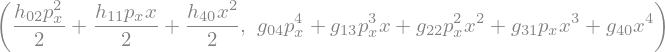

In [80]:
H2 = Rational(1,2)  * ( h20*x**2 + h11*x*px + h02*px**2 )
H4 =  g40*x**4 +  g31*x**3*px + g22*x**2*px**2 + g13*x*px**3 + g04*px**4
H2, H4

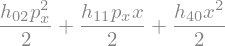

In [81]:
H2

In [82]:
H2_op = LieOperator(H2, [x], [px])
H4_op = LieOperator(H4, [x], [px])

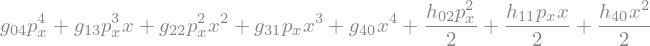

In [83]:
H4_op.BCH(H2_op,1).ham

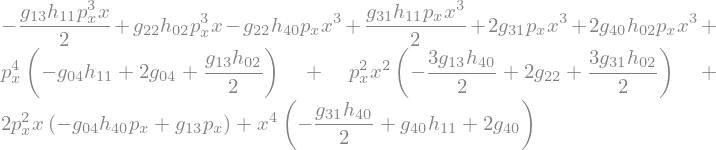

In [89]:
(H4_op.BCH(H2_op,2).doit().ham.expand()-(H2-H4)).collect(px**4).collect(x**4).collect(x*2*px**2)

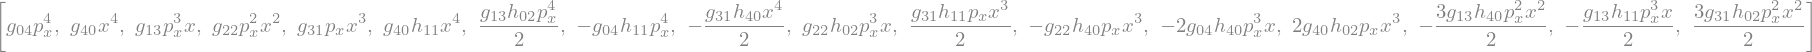

In [85]:
[a  for a in H4_op.BCH(H2_op,2).doit().ham.expand().args if Poly(a,[x,px]).total_degree()==4]

In [90]:
A,B,C = symbols("A B C")

In [132]:
ex = LieOperator(A*x**2+B*x*px+C*px**2,[x],[px]).LieMap(x,8).ham.collect(x).collect(px)
epx = LieOperator(A*x**2+B*x*px+C*px**2,[x],[px]).LieMap(px,8).ham.collect(x).collect(px)

M = Matrix([[ 0.08956728, 13.9617203 ],
       [-0.0710475 ,  0.08956728]])

In [133]:
eq1 = ex.coeff(x)- M[0,0]-1
eq2 = ex.coeff(px)- M[0,1]-1
eq3 = epx.coeff(x)- M[1,0]-1
eq4 = epx.coeff(x)- M[1,1]-1

In [137]:
from scipy.optimize import fsolve

def func(arr):

    return [
        eq1.subs(A, arr[0]).subs(B,arr[1]).subs(C,arr[2]),
        eq2.subs(A, arr[0]).subs(B,arr[1]).subs(C,arr[2]),
        eq3.subs(A, arr[0]).subs(B,arr[1]).subs(C,arr[2])
    ]

root = fsolve(func, [2, 1,12])

root

array([ 1.2042854 ,  5.87070519, 11.32087997])

In [ ]:
NL4.subs()

In [ ]:
def HQF2_symmetric_map(r0):
    _x = r[:,0]
    _px = r[:,1]
    _y = r[:,2]
    _py = r[:,3]
    _z = r[:,4]
    _pz = r[:,5]
    
    cp2 = HQ2F.coef(px**2)
    cx2 = HQ2F.coef(x**2)
    
    xn = LieOperator()
    return np.array([xn, pxn, yn, pyn, zn, pzn]).transpose()